In [1]:
import findspark
findspark.init()

In [72]:
import pyspark.sql.functions as f
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName("reddit").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/03 03:28:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/03 03:28:27 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
22/05/03 03:28:37 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [4]:
spark

In [5]:
df = spark.read.parquet('s3://cn490-project/reddit/ym_partition=202106')

# Clean data

### Timestamps

In [6]:
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

df = df.withColumn("created_utc_ts", from_unixtime(col("created_utc"),"MM-dd-yyyy HH:mm:ss")) \
    .withColumn("author_created_utc_ts", from_unixtime(col("author_created_utc"),"MM-dd-yyyy HH:mm:ss")) \

In [7]:
# Get Date
df = df.withColumn("created_date", to_date(to_timestamp("created_utc_ts",'MM-dd-yyyy HH:mm:ss'))) \
        .withColumn("author_created_date", to_date(to_timestamp("author_created_utc_ts",'MM-dd-yyyy HH:mm:ss'))) \

In [8]:
# Get Time
df = df.withColumn("created_time", date_format(to_timestamp("created_utc_ts",'MM-dd-yyyy HH:mm:ss'), 'HH:mm:ss')) \
    .withColumn("author_created_time", date_format(to_timestamp("author_created_utc_ts",'MM-dd-yyyy HH:mm:ss'), 'HH:mm:ss')) \

In [9]:
# Get Hour
df = df.withColumn("created_hour", hour(to_timestamp("created_utc_ts",'MM-dd-yyyy HH:mm:ss'))) \
        .withColumn("author_created_hour", hour(to_timestamp("author_created_utc_ts",'MM-dd-yyyy HH:mm:ss')))

### Feature engineering

In [10]:
# Account age in days
df = df.withColumn("acc_age_days", (col("created_utc") - col("author_created_utc"))/86400)

# Log transform
df = df.withColumn("log_age", log(df.acc_age_days+1)).fillna(0,subset=['log_age'])

In [11]:
# Account created hour minus post created hour 
df = df.withColumn("diff_created", pow(col("created_hour")-col("author_created_hour"),2)).fillna(-1, subset=['diff_created'])

In [12]:
# Removed body
df = df.withColumn("rm_body", F.when(col("body")=="[removed]",True).otherwise(False))
# Deleted Body
df = df.withColumn("deleted_body", F.when(col("body")=="[deleted]",True).otherwise(False))

# Negative score
df = df.withColumn("neg_score", F.when(col("score") < 0, True).otherwise(False))

# Post got deleted
df = df.withColumn("deleted_post", F.when(col("author")=="[deleted]",True).otherwise(False))

# Comment collapsed because low score
df = df.withColumn("low_score", F.when(col("collapsed_reason").isNotNull(),True).otherwise(False))

# Has flair
df = df.withColumn("has_flair", F.when(col("author_flair_text").isNotNull(),True).otherwise(False))

# Is moderator
df = df.withColumn("is_mod", F.when(col("distinguished")=='moderator',True).otherwise(False))

In [13]:
# Day of week and posted on weekend
df = df.withColumn('day_of_week', date_format("created_date", "EEEE")) \
        .withColumn("posted_on_weekend", 
                F.when(
                    (date_format("created_date", "EEEE") =='Sunday')| \
                    (date_format("created_date", "EEEE") =='Saturday') \
                     ,1).otherwise(0)) 


In [14]:
df = df.fillna({'edited':False})

# Recast boolean to integer
df = df.withColumn('is_submitter', df.is_submitter.cast(IntegerType())) \
        .withColumn('deleted_post', df.deleted_post.cast(IntegerType())) \
        .withColumn('neg_score', df.neg_score.cast(IntegerType())) \
        .withColumn('has_flair', df.has_flair.cast(IntegerType())) \
        .withColumn('locked', df.locked.cast(IntegerType())) \
        .withColumn('can_gild', df.can_gild.cast(IntegerType())) \
        .withColumn('can_mod_post', df.can_mod_post.cast(IntegerType())) \
        .withColumn('edited', df.edited.cast(IntegerType())) \
        .withColumn('stickied', df.stickied.cast(IntegerType())) \
        .withColumn('gilded', df.gilded.cast(IntegerType())) \
        .withColumn('low_score', df.low_score.cast(IntegerType())) \
        .withColumn('send_replies', df.send_replies.cast(IntegerType())) \
        .withColumn('rm_body', df.rm_body.cast(IntegerType())) \
        .withColumn('deleted_body', df.deleted_body.cast(IntegerType())) 

In [15]:
# Number of comments by same author in thread
df = df.withColumn('user_comments_in_thread', F.count('id').over(Window.partitionBy('link_id', 'author')))

# Total score by same author in thread
df = df.withColumn('user_score_in_thread', F.sum('score').over(Window.partitionBy('link_id', 'author')))

# Number of total comments in thread
df = df.withColumn('thread_total_comments', F.count('id').over(Window.partitionBy('link_id')))

In [16]:
# Number of distinct users in thread

df = df.withColumn('users_in_thread', F.approx_count_distinct('author').over(Window.partitionBy('link_id')))

### Tokenize text columns

In [17]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="body", outputCol="tokenized_body")

countTokens = udf(lambda words: len(words), IntegerType())
df = tokenizer.transform(df)

In [18]:
df = df.withColumn("comment_length", countTokens(col("tokenized_body"))) 

In [19]:
# replace null with empty string
df = df.fillna({'author_flair_text':" "})

flair_tokenizer = Tokenizer(inputCol="author_flair_text", outputCol="tokenized_flair")
df = flair_tokenizer.transform(df)

In [20]:
df = df.withColumn("flair_length", size(col("tokenized_flair")))

# Dataset

In [21]:
data = df.select('is_submitter',
                 'day_of_week',
                 'score','log_age',
                 'deleted_post','neg_score','diff_created',
                 'has_flair','comment_length','flair_length','is_mod',
                 'user_comments_in_thread','user_score_in_thread','users_in_thread','thread_total_comments',
                 'can_gild','can_mod_post','edited','stickied','locked','gilded',
                 'rm_body','deleted_body','send_replies'
                )

data.createOrReplaceTempView("data")

22/05/03 03:28:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [22]:
data.printSchema()

root
 |-- is_submitter: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- score: long (nullable = true)
 |-- log_age: double (nullable = false)
 |-- deleted_post: integer (nullable = false)
 |-- neg_score: integer (nullable = false)
 |-- diff_created: double (nullable = false)
 |-- has_flair: integer (nullable = false)
 |-- comment_length: integer (nullable = true)
 |-- flair_length: integer (nullable = false)
 |-- is_mod: boolean (nullable = false)
 |-- user_comments_in_thread: long (nullable = false)
 |-- user_score_in_thread: long (nullable = true)
 |-- users_in_thread: long (nullable = false)
 |-- thread_total_comments: long (nullable = false)
 |-- can_gild: integer (nullable = true)
 |-- can_mod_post: integer (nullable = true)
 |-- edited: integer (nullable = true)
 |-- stickied: integer (nullable = true)
 |-- locked: integer (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- rm_body: integer (nullable = false)
 |-- deleted_body: integer (nullabl

In [23]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 260670


Number of testing records : 65305


# EDA

### Unbalanced class

In [36]:
train_data.createOrReplaceTempView("trdf")

In [37]:
spark.sql('''
    SELECT is_submitter, COUNT(*) as count
    FROM trdf
    GROUP BY is_submitter
    ORDER BY count desc;
    ''').show()


+------------+------+
|is_submitter| count|
+------------+------+
|           0|226085|
|           1| 34585|
+------------+------+



### Comment length

In [83]:
pddf = spark.sql('''
    SELECT *
    FROM trdf;
    ''').toPandas()

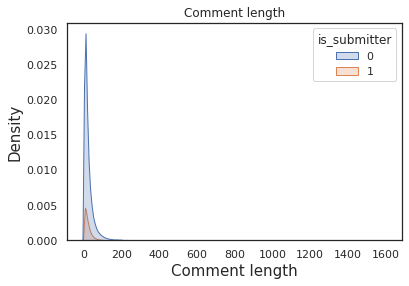

In [85]:
sns.set_theme(style="white")
p = sns.kdeplot(data=pddf,x='comment_length', hue="is_submitter",
           fill=True, common_norm=True, 
            alpha=.25, linewidth=1,
               )
p.set_xlabel("Comment length", fontsize = 15)
p.set_ylabel("Density", fontsize = 15)
p.set_title("Comment length")

plt.savefig('submitter_length.png')

# User_comments_in_thread

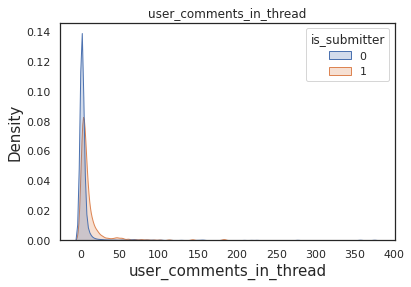

In [90]:
sns.set_theme(style="white")
p = sns.kdeplot(data=pddf,x='user_comments_in_thread', hue="is_submitter",
           fill=True, common_norm=False,
            alpha=.25, linewidth=1,
               )
p.set_xlabel("user_comments_in_thread", fontsize = 15)
p.set_ylabel("Density", fontsize = 15)
p.set_title("user_comments_in_thread")

plt.savefig('submitter_user_comments_in_thread.png')

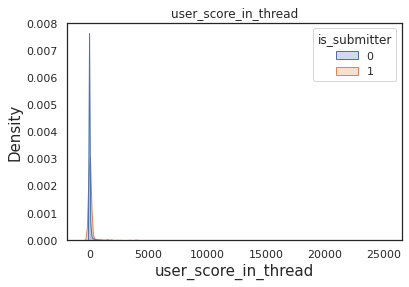

In [92]:
sns.set_theme(style="white")
p = sns.kdeplot(data=pddf,x='user_score_in_thread', hue="is_submitter",
           fill=True, common_norm=False,
            alpha=.25, linewidth=1,
               )
p.set_xlabel("user_score_in_thread", fontsize = 15)
p.set_ylabel("Density", fontsize = 15)
p.set_title("user_score_in_thread")

plt.savefig('submitter_user_score_in_thread.png')

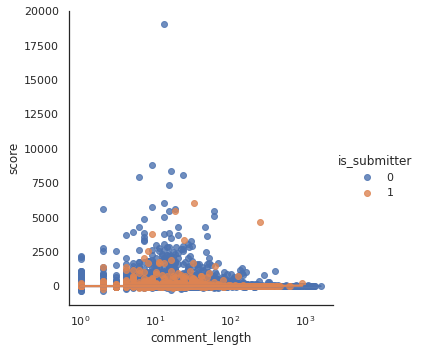

In [102]:
p = sns.lmplot(data = pddf, x = 'comment_length', y='score', hue = 'is_submitter')
p.set(xscale="log")

plt.savefig('score_comment_length.png')

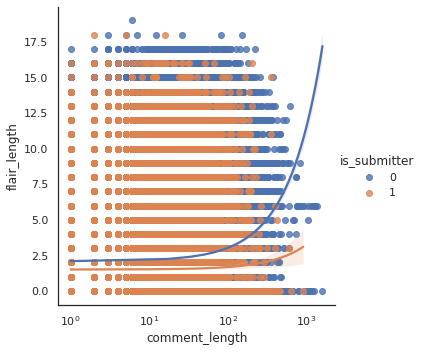

In [105]:
p = sns.lmplot(data = pddf, x = 'comment_length', y = 'flair_length', hue = 'is_submitter')
p.set(xscale="log")
      
plt.savefig('comment_flair_length')

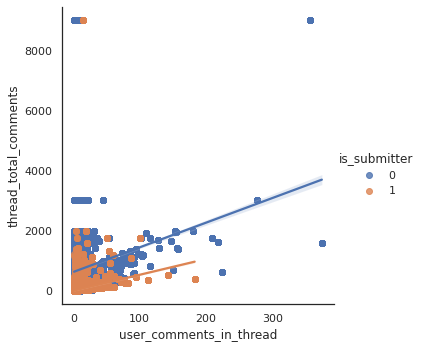

In [108]:
p = sns.lmplot(data = pddf, x = 'user_comments_in_thread', y = 'thread_total_comments', hue = 'is_submitter')
      
plt.savefig('user_in_thread')